In [2]:
import numpy as np

### Layer Abstract Class

In [3]:
class Layer():
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, accum_grad, learning_rate):
        raise NotImplementedError()       

### Dense Layer

In [106]:
import math

class Dense(Layer):
    def __init__(self, input_dim, output_dim):
        # Reference : https://keras.io/api/layers/initializers/
        limit = np.sqrt(6/(input_dim+output_dim))
        self.W = np.random.uniform(-limit, limit, size=(input_dim, output_dim))
        #self.W = np.random.randn(input_dim, output_dim) * 0.1
        self.b = np.zeros(output_dim)
        self.x_save = None # saving input x in forward step for using in backward step
        
    def forward(self, x):
        # x : (batch, input_dim)
        self.x_save = x
        
        # Dense layer를 수식으로 표현하면 다음과 같습니다.
        # y = x@W + b
        
        # (batch, output_dim)
        y = x @ self.W + self.b
        
        return y
        
    def backward(self, accum_grad, learning_rate):
        # accum_grad : ∂L/∂y, (batch, output_dim)
        
        # y를 W에 대해 미분하면 다음과 같이 되고,
        # ∂y/∂W = x
        
        # Loss를 W에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂W = ∂L/∂y·∂y/∂W = ∂L/∂y·x
        
        # (input_dim, output_dim)
        W_grad = self.x_save.T @ accum_grad
        
        # 또한 y를 b에 대해 미분하면 다음과 같이 되고,
        # ∂y/∂b = 1
        
        # Loss를 b에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂b = ∂L/∂y·∂y/∂b = ∂L/∂y·1
        b_grad = np.sum(accum_grad, axis=0)
        
        # Loss를 x에 대해 미분하면 chain rule에 의해 다음과 같이 표현됩니다.
        # ∂L/∂x = ∂L/∂y·∂y/∂x
        # y를 x에 대해 미분하면 다음과 같이 됩니다.
        # ∂y/∂x = W
        accum_grad = accum_grad @ self.W.T

        # Weight&bias 업데이트
        self.W = self.W - learning_rate * W_grad
        self.b = self.b - learning_rate * b_grad
        
        return accum_grad
            

### Activations

In [44]:
# Reference : https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/deep_learning/activation_functions.py
class Sigmoid(Layer):
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, accum_grad, learning_rate):
        grad = self.forward(accum_grad) * (1 - self.forward(accum_grad))
        return accum_grad * grad

class ReLU(Layer):
    def forward(self, x):
        return np.where(x>=0, x, 0)
    
    def backward(self, accum_grad, learning_rate):
        grad = np.where(accum_grad>=0, 1, 0)
        grad = 1
        return accum_grad * grad
    
class LeakyReLU(Layer):
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        
    def forward(self, x):
        return np.where(x>=0, x, self.alpha*x)
    
    def backward(self, accum_grad, learning_rate):
        grad = np.where(accum_grad>=0, 1, self.alpha)
        return accum_grad * grad
    
class Tanh(Layer):
    def forward(self, x):
        return 2 / (1 + np.exp(-2*x)) - 1
    
    def backward(self, accum_grad, learning_rate):
        forward_value = self.forward(accum_grad)
        grad = 1 - np.power(forward_value, 2)
        return accum_grad * grad
        

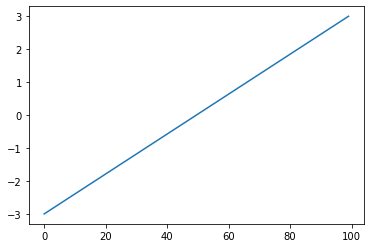

In [45]:
t = np.linspace(-3, 3, 100)
t = ReLU().backward(t, learning_rate=1e-3)
import matplotlib.pyplot as plt

plt.plot(t)
plt.show()

### Sequential Layer

In [6]:
class Sequential(Layer):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        # x : (batch, input_dim)
        
        for layer in self.layers:
            x = layer.forward(x)
            
        return x
    
    def backward(self, accum_grad, learning_rate):
        
        for layer in reversed(self.layers):
            accum_grad = layer.backward(accum_grad, learning_rate)
            
        return accum_grad

### Losses

In [7]:
class MeanSquareError():
    @staticmethod
    def get_loss(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch, dim)
        
        # scalar
        loss = 0.5 * np.mean((y_pred - y_true) ** 2)
        
        return loss
    
    @staticmethod
    def get_gradient(y_pred, y_true):
        grad = -y_true + y_pred
        
        return grad
    
from scipy.special import softmax
class SparseCrossEntropy():
    # Reference : https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
    @staticmethod
    def get_loss(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch,)
        
        eps = np.finfo(float).eps
        log_p = np.log(softmax(y_pred, axis=1) + eps)
        
        negative_log_likelihoods = []
        for i, target in enumerate(y_true):
            nll = -log_p[i, target]
            negative_log_likelihoods.append(nll)
            
        loss = np.mean(negative_log_likelihoods)
        
        return loss
    
    @staticmethod
    def get_gradient(y_pred, y_true):
        # y_pred : (batch, dim)
        # y_true : (batch,)
        
        y_true = np.eye(y_pred.shape[1])[y_true]
        grad = softmax(y_pred, axis=1) - y_true
        return grad
    

### Data preparation

In [50]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.fillna(dataset.mean())

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_train_data.shape, normed_test_data.shape)
print(train_labels.shape, test_labels.shape)

(318, 9) (80, 9)
(318,) (80,)


### Model setup

In [128]:
model = Sequential([Dense(9, 64),
                    ReLU(),
                    Dense(64, 64),
                    ReLU(),
                    Dense(64, 1),
                   ])
print(model)

In [129]:
losses = []

x = normed_train_data.to_numpy()
t = train_labels.to_numpy().reshape(-1, 1)

from tqdm import tqdm
for i in range(100):
    
    # Forward Pass
    y = model.forward(x)
    
    # Get Loss
    loss = MeanSquareError.get_loss(y, t)
    print('Epoch :', i, 'Loss :', loss)
    
    # Backward Pass
    grad = MeanSquareError.get_gradient(y, t)
    model.backward(grad, learning_rate=1e-5)
    
    # Append loss
    losses.append(loss)
    
print('done')

Epoch : 0 Loss : 305.327717056786
Epoch : 1 Loss : 290.5875506911777
Epoch : 2 Loss : 274.92009704230685
Epoch : 3 Loss : 256.66222036823706
Epoch : 4 Loss : 234.1659722292972
Epoch : 5 Loss : 205.73935578641863
Epoch : 6 Loss : 170.26134749810498
Epoch : 7 Loss : 128.57987392079878
Epoch : 8 Loss : 85.55572963064706
Epoch : 9 Loss : 50.15072218492715
Epoch : 10 Loss : 28.475763265935882
Epoch : 11 Loss : 17.630356551572717
Epoch : 12 Loss : 12.035702038972309
Epoch : 13 Loss : 8.937531808907158
Epoch : 14 Loss : 7.2566255662488155
Epoch : 15 Loss : 6.369016861863669
Epoch : 16 Loss : 5.886809198544633
Epoch : 17 Loss : 5.601826055933411
Epoch : 18 Loss : 5.415106198846651
Epoch : 19 Loss : 5.281266394061328
Epoch : 20 Loss : 5.178811227742165
Epoch : 21 Loss : 5.097013269450494
Epoch : 22 Loss : 5.030013199243375
Epoch : 23 Loss : 4.973967288046838
Epoch : 24 Loss : 4.926344749283933
Epoch : 25 Loss : 4.885291285209844
Epoch : 26 Loss : 4.849460379585968
Epoch : 27 Loss : 4.8178342107

### Test

(80, 9)


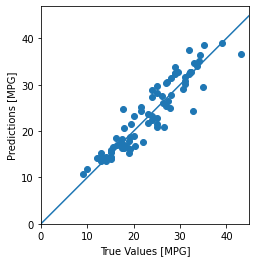

In [131]:
x_test = normed_test_data.to_numpy()
t_test = test_labels.to_numpy().reshape(-1, 1)
y_test = model.forward(x_test)

plt.scatter(t_test[:, 0], y_test[:,0 ])
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])